In [1]:
import sys
import pandas as pd
import numpy as np

sys.path.append('/opt/hydra/')

import library.analysis as hydra

In [2]:
exp_path = '../data/TH-ALVEOLAR-log2TPM1.tsv'
mm_path = '../data/hydra-alveolar/MultiModalGenes'

In [3]:
exp = pd.read_csv(exp_path, sep='\t', index_col=0)

In [4]:
exp.shape

(16619, 44)

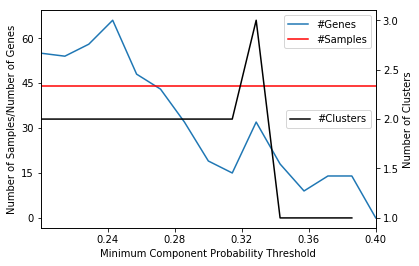

In [25]:
scan = hydra.ScanEnrichmentAnalysis(mm_path, 
                                    exp_path, 
                                    'GO',
                                     #min_prob_range=[0.25, 0.33, 0.35],
                                     min_prob_range=np.linspace(0.2, 0.4, 15),
                                     K=5).scan()

In [8]:
scan

,num_genesets,gs_terms,gs_term_genes,num_genes,num_clusters,num_samples
min_prob_filter,,,,,,
0.200000,6,humoral immune response mediated by circulatin...,IGLV2-8|LIN7A|IGHV3-15|SYT4|IGHV1-18|IGHV3-11|...,55,2,44
0.214286,6,humoral immune response mediated by circulatin...,IGLV2-8|SLC6A3|IGHV3-15|SYT4|IGHV1-18|IGHV3-11...,54,2,44
0.228571,7,humoral immune response mediated by circulatin...,IGLV2-8|SLC6A3|KCNC2|IGHV3-15|DRD2|IGHV1-18|IG...,58,2,44
0.242857,9,humoral immune response mediated by circulatin...,IGLV2-8|SLC6A3|KCNC2|EPHA8|IGHV3-15|DRD2|IGHV1...,66,2,44
0.257143,5,humoral immune response mediated by circulatin...,IGLV2-8|SLC6A3|IGHV3-15|DRD2|IGHV1-18|IGKV1-16...,48,2,44
0.271429,6,humoral immune response mediated by circulatin...,SLC6A3|IGHV3-15|DRD2|IGHV1-18|IGKV1-16|IGKV1-1...,43,2,44
0.285714,3,"complement activation, classical pathway|plasm...",SLC6A3|IGHV3-15|IGHV1-18|IGKV1-16|IGKV1-17|SRR...,32,2,44
0.300000,2,"complement activation, classical pathway|plasm...",IGHV1-69-2|IGKV1-5|IGHV3-15|IGLV3-21|IGKV1-16|...,19,2,44
0.314286,1,"complement activation, classical pathway",IGKV1-5|IGHV3-15|IGLV3-21|IGKV1-16|IGLV3-25|IG...,15,2,44


In [26]:
en = hydra.EnrichmentAnalysis(exp_path=exp_path,
                              mm_path=mm_path,
                              gmt_path='GO',
                              min_prob_filter=0.33)

In [27]:
en.get_enriched_terms()

,Unnamed: 0,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
0,GO:0030900,GO:0030900,forebrain development,12/74,276/11952,1.110941e-07,0.000085,0.000070,SLC6A3/IGF2BP1/NR0B1/TH/ADCYAP1/PAX5/KCNC2/EFN...,12
1,GO:0060415,GO:0060415,muscle tissue morphogenesis,7/74,64/11952,1.223908e-07,0.000085,0.000070,MYL3/RYR2/PAX7/XIRP2/MYH7/MYF5/MYF6,7
2,GO:0048644,GO:0048644,muscle organ morphogenesis,7/74,67/11952,1.688270e-07,0.000085,0.000070,MYL3/RYR2/PAX7/XIRP2/MYH7/MYF5/MYF6,7
3,GO:0006958,GO:0006958,"complement activation, classical pathway",7/74,74/11952,3.375347e-07,0.000127,0.000105,IGHV3-15/IGHV4-59/IGHV3-23/IGHV3-33/IGLV2-11/I...,7
4,GO:0006909,GO:0006909,phagocytosis,8/74,240/11952,1.131190e-04,0.006721,0.005543,IGHV3-15/ITGAL/IGHV4-59/IGHV3-23/IGHV3-33/IGLV...,8
5,GO:0097553,GO:0097553,calcium ion transmembrane import into cytosol,5/74,94/11952,2.838022e-04,0.010685,0.008813,RYR2/CXCL9/CCL19/TRDN/FAM155A,5
6,GO:0002026,GO:0002026,regulation of the force of heart contraction,3/74,22/11952,3.224169e-04,0.011561,0.009535,MYL3/RYR2/MYH7,3


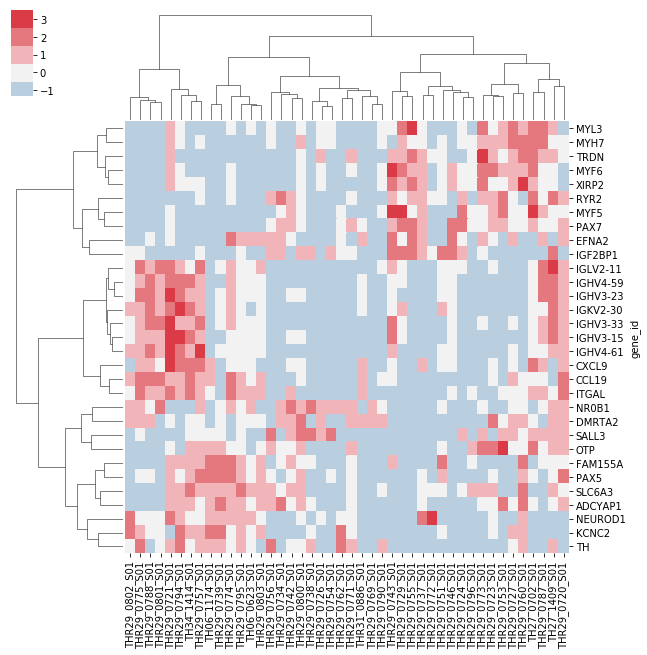

In [28]:
hclust = hydra.HClust(exp.reindex(en.get_enriched_term_genes()))
hclust.plot()

In [29]:
clust = hydra.MultivariateMixtureModel(data=exp.reindex(en.get_enriched_term_genes()),
                                       center=True,
                                       gamma=5.0,
                                       variance=2.0,
                                       K=1)

In [30]:
fgsea = clust.get_cluster_features(exp=exp,
                                   gmt='/opt/hydra/gene-sets/Human_GOBP_AllPathways_no_GO_iea_December_01_2018_symbol.gmt')

In [32]:
def format_pathway(x):
    fields = x.split('%')
    return '%s (%s)' % (fields[0], fields[1])

In [33]:
fgsea_df = None
for key, values in fgsea.items():
    if fgsea_df is None:
        header = pd.MultiIndex.from_product([list(fgsea.keys()), 
                                             ['padj', 'NES']],
                                           names=['cluster', 'feature'])
        
        fgsea_df = pd.DataFrame(index=values.index.values, columns=header)
        
    print 'Key: ', key,
    t = values.reset_index().reindex(['pathway', 'padj', 'NES'], axis=1)
    t['pathway'] = t['pathway'].apply(format_pathway) 
    print(t[(t['NES'] > 0) & (t['padj'] < 0.05)].sort_values('NES', ascending=False).head(10))
    
    fgsea_df[(key, 'padj')] = values.loc[fgsea_df.index, 'padj'].values
    fgsea_df[(key, 'NES')] = values.loc[fgsea_df.index, 'NES'].values

Key:  0                                               pathway      padj       NES
0                               KERATINIZATION (GOBP)  0.016485  3.002217
1    KERATINIZATION (REACTOME DATABASE ID RELEASE 66)  0.016189  2.855529
2                                CORNIFICATION (GOBP)  0.016189  2.855529
3   ALANINE AND ASPARTATE METABOLISM (WIKIPATHWAYS...  0.013283  2.802517
5                SMOOTH MUSCLE CONTRACTION (REACTOME)  0.018551  2.716819
6                 KERATINOCYTE DIFFERENTIATION (GOBP)  0.019480  2.698940
7       PLASMA LIPOPROTEIN PARTICLE REMODELING (GOBP)  0.014344  2.665702
8             PROTEIN-LIPID COMPLEX REMODELING (GOBP)  0.014344  2.665702
9   PROSTAGLANDIN SYNTHESIS AND REGULATION (WIKIPA...  0.018342  2.658544
10                FATTY ACID METABOLIC PROCESS (GOBP)  0.048415  2.545096
Key:  1                                              pathway      padj       NES
0           HALLMARK_ALLOGRAFT_REJECTION (MSIGDB_C2)  0.012931  4.771525
1                    ADA

In [34]:
pth = '../data/TH-aRMS-Pathways-Enrichment.tsv'
fgsea_df.to_csv(pth, sep='\t')

In [31]:
cpth = '../img/TH-aRMS-top-10-pathways-cluster-%d.tex'
for key, values in fgsea.items():
    with pd.option_context('display.precision', 2):
        t = values.reset_index().reindex(['pathway', 'padj', 'NES'], axis=1)
        t['pathway'] = t['pathway'].apply(format_pathway)
        with open(pth % key, 'w') as f:
            print(t[(t['NES'] > 0) & (t['padj'] < 0.05)].sort_values('NES', ascending=False).head(10).to_latex(index=False))
            t[(t['NES'] > 0) & (t['padj'] < 0.05)].sort_values('NES', ascending=False).head(10).to_latex(f, index=False)

\begin{tabular}{lrr}
\toprule
                                           pathway &  padj &   NES \\
\midrule
                             KERATINIZATION (GOBP) &  0.02 &  3.00 \\
  KERATINIZATION (REACTOME DATABASE ID RELEASE 66) &  0.02 &  2.86 \\
                              CORNIFICATION (GOBP) &  0.02 &  2.86 \\
 ALANINE AND ASPARTATE METABOLISM (WIKIPATHWAYS... &  0.01 &  2.80 \\
              SMOOTH MUSCLE CONTRACTION (REACTOME) &  0.02 &  2.72 \\
               KERATINOCYTE DIFFERENTIATION (GOBP) &  0.02 &  2.70 \\
     PLASMA LIPOPROTEIN PARTICLE REMODELING (GOBP) &  0.01 &  2.67 \\
           PROTEIN-LIPID COMPLEX REMODELING (GOBP) &  0.01 &  2.67 \\
 PROSTAGLANDIN SYNTHESIS AND REGULATION (WIKIPA... &  0.02 &  2.66 \\
               FATTY ACID METABOLIC PROCESS (GOBP) &  0.05 &  2.55 \\
\bottomrule
\end{tabular}

\begin{tabular}{lrr}
\toprule
                                           pathway &  padj &   NES \\
\midrule
          HALLMARK\_ALLOGRAFT\_REJECTION (MSIGDB\_C2) &

In [17]:
assignments = clust.get_assignments(exp.reindex(en.get_enriched_term_genes()))

assign = pd.DataFrame(index=exp.columns,
                      columns=[1])

for sample, assignment in zip(exp.columns, assignments):
    assign.loc[sample, 1] = assignment + 1

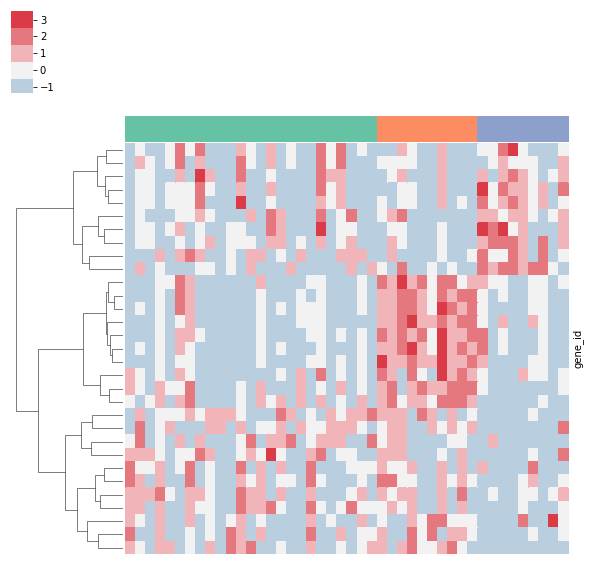

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

col_order = assign.sort_values(1).index.values
cmap = sns.color_palette("Set2", max(assign[1].values))
col_colors = [cmap[x - 1] for x in assign.sort_values(1)[1].values]

g = sns.clustermap(exp.reindex(en.get_enriched_term_genes()).reindex(col_order, axis=1),
                   col_cluster=False,
                   col_colors=col_colors,
                   z_score=0,
                   method='ward',
                   center=0,
                   cmap=sns.diverging_palette(240, 10, n=7),
                   figsize=(10, 10))

ax = g.ax_heatmap

ax.set_xticklabels([])
ax.set_xticks([])
ax.set_yticklabels([])
ax.set_yticks([])

pth = '../img/aRMS-expression-heatmap.svg'
plt.savefig(pth, format='svg', bbox_inches='tight')

pth = '../img/aRMS-expression-heatmap.png'
plt.savefig(pth, format='png', bbox_inches='tight')

In [19]:
def format_pathway(x):
    fields = x.split('%')
    return '%s (%s)' % (fields[0], fields[1])

In [20]:
for key, values in fgsea.items():
    print 'Key: ', key,
    t = values.reset_index().reindex(['pathway', 'padj', 'NES'], axis=1)
    t['pathway'] = t['pathway'].apply(format_pathway) 
    print(t[(t['NES'] > 0) & (t['padj'] < 0.05)].sort_values('NES', ascending=False).head(10))

Key:  0                                               pathway      padj       NES
0                               KERATINIZATION (GOBP)  0.015964  3.026013
2                                CORNIFICATION (GOBP)  0.015814  2.856716
1    KERATINIZATION (REACTOME DATABASE ID RELEASE 66)  0.015814  2.856716
4   ALANINE AND ASPARTATE METABOLISM (WIKIPATHWAYS...  0.012604  2.794339
5                SMOOTH MUSCLE CONTRACTION (REACTOME)  0.018139  2.734273
6                 KERATINOCYTE DIFFERENTIATION (GOBP)  0.018459  2.730863
7   PROSTAGLANDIN SYNTHESIS AND REGULATION (WIKIPA...  0.017835  2.689171
8             PROTEIN-LIPID COMPLEX REMODELING (GOBP)  0.013851  2.675364
9       PLASMA LIPOPROTEIN PARTICLE REMODELING (GOBP)  0.013851  2.675364
10          ARACHIDONIC ACID METABOLIC PROCESS (GOBP)  0.015964  2.548190
Key:  1                                              pathway      padj       NES
0           HALLMARK_ALLOGRAFT_REJECTION (MSIGDB_C2)  0.012011  4.779863
1                    ADA

In [21]:
pth = '../img/TH-aRMS-top-10-pathways-cluster-%d.tex'
for key, values in fgsea.items():
    with pd.option_context('display.precision', 2):
        t = values.reset_index().reindex(['pathway', 'padj', 'NES'], axis=1)
        t['pathway'] = t['pathway'].apply(format_pathway)
        with open(pth % key, 'w') as f:
            print(t[(t['NES'] > 0) & (t['padj'] < 0.05)].sort_values('NES', ascending=False).head(10).to_latex(index=False))
            t[(t['NES'] > 0) & (t['padj'] < 0.05)].sort_values('NES', ascending=False).head(10).to_latex(f, index=False)

\begin{tabular}{lrr}
\toprule
                                           pathway &  padj &   NES \\
\midrule
                             KERATINIZATION (GOBP) &  0.02 &  3.03 \\
                              CORNIFICATION (GOBP) &  0.02 &  2.86 \\
  KERATINIZATION (REACTOME DATABASE ID RELEASE 66) &  0.02 &  2.86 \\
 ALANINE AND ASPARTATE METABOLISM (WIKIPATHWAYS... &  0.01 &  2.79 \\
              SMOOTH MUSCLE CONTRACTION (REACTOME) &  0.02 &  2.73 \\
               KERATINOCYTE DIFFERENTIATION (GOBP) &  0.02 &  2.73 \\
 PROSTAGLANDIN SYNTHESIS AND REGULATION (WIKIPA... &  0.02 &  2.69 \\
           PROTEIN-LIPID COMPLEX REMODELING (GOBP) &  0.01 &  2.68 \\
     PLASMA LIPOPROTEIN PARTICLE REMODELING (GOBP) &  0.01 &  2.68 \\
         ARACHIDONIC ACID METABOLIC PROCESS (GOBP) &  0.02 &  2.55 \\
\bottomrule
\end{tabular}

\begin{tabular}{lrr}
\toprule
                                           pathway &  padj &   NES \\
\midrule
          HALLMARK\_ALLOGRAFT\_REJECTION (MSIGDB\_C2) &